In [1]:
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Custom config class to globally change some parameters
class Config:
    run_tests: bool
    do_print: bool

Config.run_tests = True
Config.do_print = True

# TODO Assign seed (np.random)

# Please Run All cells now before reading on

## For peer-reviewing the report, scroll down to the H1 header "Start of Pipeline"

You can also collapse the header **Function implementations** to get there quickly

# Function implementations

The functions below are for reference only. The WebLab functions are to be graded. These may have changed to accomodate our pipelines.

## Spectral embeddings
### Provided design specification
Implement the computation of [spectral embeddings](https://en.wikipedia.org/wiki/Spectral_clustering#Algorithms) for **undirected graphs**.

- The function to implement is `compute_spectral_embeddings`.
- The input is an undirected [networkx.Graph](https://networkx.org/documentation/stable/reference/classes/graph.html).
- The node IDs in this graph are integers from `0` to `n`.
- The output should be a numpy array of shape `(num_nodes, dim)`. Each row corresponds to a node representation. Rows should be ordered by node ID (ascending).
- The Laplacian should not be normalized.
- You have to use [numpy.linalg.eigh](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html) to compute eigenvalues and eigenvectors in order for the tests to work.
- This task focuses on computing the node representations. You do not need to run an actual clustering algorithm (e.g., k-means).


In [2]:
# Spectral embeddings implementation and tests

def compute_spectral_embeddings(graph: nx.Graph, dim: int) -> np.ndarray:
    """Perform spectral clustering on the graph and compute low-dimensional node representations.
    Does not normalize the Laplacian.

    Args:
        graph (nx.Graph): The graph.
        dim (int): The dimension of representations. This corresponds to the number of eigenvectors used.

    Returns:
        np.ndarray: Node representations (sorted by node ID, ascending), shape (num_nodes, dim).
    """
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))

    # make sure the matrix is symmetric
    assert (adjacency_matrix == adjacency_matrix.T).all()

    result = None

    # START ANSWER
    # Type hinting for ease of programming
    adjacency_matrix: np.ndarray

    # Calculate the out degrees of the nodes by summing adjacencies
    degrees = np.sum(adjacency_matrix, axis=0)
    
    # Construct the Laplacian matrix
    # First we fill the diagonal with the node degrees
    laplacian = np.zeros(adjacency_matrix.shape)
    np.fill_diagonal(laplacian, degrees)

    # Complete the Laplacian matrix by subtracting the adjacancy matrix
    laplacian -= adjacency_matrix

    # Next: calculating the eigenvalues and -vectors
    _eigh = np.linalg.eigh(laplacian)
    eigenvalues, eigenvectors = (_eigh.eigenvalues, _eigh.eigenvectors)
    eigenvalues_sort_indices = np.argsort(eigenvalues)

    eigenvalues = eigenvalues[eigenvalues_sort_indices]
    eigenvectors = eigenvectors[eigenvalues_sort_indices]
    
    result = eigenvectors[:,0:dim]
    # END ANSWER

    return result

if Config.run_tests:
    import unittest
    
    class TestComponents(unittest.TestCase):
        def setUp(self):
            self.simple_graph = nx.Graph(
                [(0, 3), (1, 3), (2, 4), (3, 5), (3, 6), (4, 6), (5, 6), (5, 4)]
            )

        def test_spectral_embeddings(self):
            emb = compute_spectral_embeddings(self.simple_graph, 3)
            np.testing.assert_almost_equal(
                np.array(
                    [
                        [3.77964473e-01, -4.49723806e-01, 7.07106781e-01],
                        [3.77964473e-01, -4.49723806e-01, -7.07106781e-01],
                        [3.77964473e-01, 6.59857436e-01, -1.66533454e-15],
                        [3.77964473e-01, -2.18583490e-01, 1.11022302e-16],
                        [3.77964473e-01, 3.20716714e-01, 6.59900940e-16],
                        [3.77964473e-01, 6.87284763e-02, 1.14927529e-15],
                        [3.77964473e-01, 6.87284763e-02, 1.26029760e-15],
                    ]
                ),
                emb,
            )

    unittest.main(argv=[''], verbosity=2, exit=False)

test_spectral_embeddings (__main__.TestComponents.test_spectral_embeddings) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.017s

OK


## Random Walks implementation
### Provided design specification
Implement [random walks](https://en.wikipedia.org/wiki/Random_walk). You can assume that the graph does not have weighted edges.

The function to implement is `random_walks`.
The input is an undirected [networkx.Graph](https://networkx.org/documentation/stable/reference/classes/graph.html).
The output should be a numpy array, shape `(num_nodes * num_walks, walk_length)`.

In [3]:
# Timo's random walks implementation and tests
def random_walks_weblab(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    """Perform random walks on an unweighted graph.

    Args:
        graph (nx.Graph): The graph.
        num_walks (int): The number of random walks for each node.
        walk_length (int): The number of nodes in a random walk.

    Returns:
        np.ndarray: The random walks, shape (n_nodes * num_walks, walk_length)
    """
    result = []

    # START ANSWER
    # Iterate over all the nodes in the graph
    for start_node_id in graph.nodes:
        # Type hinting
        start_node_id: int
        
        # Do a number of walks per node equal to num_walks
        for walk_id in range(num_walks):
            walk = []
            # Append the starting node to our walk, and set it as the current node
            walk.append(start_node_id)
            current_node: int = start_node_id
            
            # Do a number of steps equal to walk_length - 1, because we already have the start node in our walk
            for step in range(walk_length - 1):
                # Get the neighbours of the current node
                neighbours = graph.adj[current_node]
                
                # Pick one at random to walk to next
                next = np.random.choice(neighbours)
                
                # Append it to our walk, and set it as the new current node
                walk.append(next)
                current_node = next
            
            # Append the walk to our results
            result.append(walk)
    # END ANSWER

    return np.array(result)

if Config.run_tests:
    import unittest

    class TestComponents(unittest.TestCase):
        def setUp(self):
            self.simple_graph = nx.Graph(
                [(0, 3), (1, 3), (2, 4), (3, 5), (3, 6), (4, 6), (5, 6), (5, 4)]
            )

        def test_random_walks(self):
            result = random_walks_weblab(self.simple_graph, 2, 5)
            self.assertEqual((7 * 2, 5), result.shape)
            for n in result.flatten():
                self.assertIn(n, self.simple_graph.nodes)

    unittest.main(argv=[''], verbosity=2, exit=False)

test_random_walks (__main__.TestComponents.test_random_walks) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


# Start of Pipeline

Analysis and discussion is done after the full pipeline

## Medium Articles Dataset

We provide a dataset of medium articles which have to be tagged to corresponding topics (software-development, artificial intellignece, Ui/UX). Along with articles we have subscriptions lists. The articles may be related by common subscription lists. The goal is to exploit this naturally occuring network structure for classifying articles to topics. Hence, it is a 3-way node classification task

In [4]:
def read_data(dir_name: str, file_name: str):
    """Read the medium articles with lists

    Args:
        dir_name (str): Root directory of the medium title files and lists.

    Returns:
        final_data: merged dataframes with articles and lists
    """

    final_data = pd.read_csv(dir_name+"/"+file_name+".csv")
    return final_data

In [5]:
final_data = pd.read_csv("data/pipeline_assignment_data/full_data_without_labels.csv")
final_data

,article,title,subtitle,author,date,list
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,https://medium.com/@zemmali1990/list/aws-49f68...
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,https://medium.com/@TomaszCieplak/list/graph-d...
2,https://medium.com/@sarafparam/transformers-fo...,Transformers for Time-Series,Forecasting still remains to be dominated by S...,Param Saraf,2020-10-20,https://medium.com/@sergiobonato/list/time-ser...
3,https://medium.com/towards-data-science/review...,Reviewing A/B Testing Course by Google on Udacity,Read to find out how A/B tests are performed a...,Suyash Maheshwari,2020-05-10,https://medium.com/@online.rajib/list/ml-c2cac...
4,https://medium.com/towards-data-science/a-comp...,A Comprehensive Hands-on Guide to Transfer Lea...,Deep Learning on Steroids with the Power of Kn...,Dipanjan (DJ) Sarkar,2018-11-14,https://medium.com/@farhanhanavi07/list/deep-l...
...,...,...,...,...,...,...
27713,https://medium.com/cometheartbeat/deep-learnin...,Deep Learning Techniques you Should Know in 2022,"Over the years, Deep Learning has really taken...",Nisha Arya Ahmed,2022-04-21,https://medium.com/@vigguvenki/list/deep-learn...
27714,https://medium.com/towardsdev/intro-to-object-...,Intro to Object-Oriented Programming For Data ...,Implement a simple Linear Regression with OOP ...,Bex T.,2021-04-12,https://medium.com/@or.matalon2/list/oop-4aad5...
27715,https://medium.com/towards-data-science/learn-...,Learn Enough Docker to be Useful,Part 1: The Conceptual Landscape — Containers ...,Jeff Hale,2019-01-09,https://medium.com/@vaibhavb2473/list/machine-...
27716,https://medium.com/berndruecker/moving-from-em...,Moving from embedded to remote workflow engines,"For a long time, we have advocated for an arch...",Bernd Rücker,2022-02-08,https://medium.com/@giamma80/list/java-3c31810...


In [6]:
train = read_data("data/pipeline_assignment_data","train")
train

,index,article,title,subtitle,author,date,list,labels
0,3279,https://medium.com/dev-genius/how-to-convert-m...,How to Convert MP4 Videos to Animated GIFs,With Kazam and ffmpeg on GNU/Linux systems — I...,Jordi Bassaganas,2022-06-02,https://medium.com/@zzpzaf.se/list/var-4f4a92d...,software-development
1,26139,https://medium.com/towards-data-science/a-cust...,"Custom SpaCy Model Deployment with AWS ECR, Sa...",A tutorial on how to deploy SpaCy with AWS. — ...,Cheng,2021-06-04,https://medium.com/@munivinayk/list/nlp-242e66...,artificial-intelligence
2,9946,https://medium.com/towards-data-science/5-book...,5 Books To Grow As A Leader In Data Analytics,Are you a senior analyst growing towards a man...,Valentin Mucke,2022-01-15,https://medium.com/@Nikhil_Phadtare/list/books...,artificial-intelligence
3,2353,https://medium.com/@unsuitable001/package-cron...,"package:cronet, an HTTP Dart/Flutter package w...",My Dart Google Summer of Code 2021 experience....,Soumyadip Monda,2021-08-21,https://medium.com/@djibi.jb/list/flutter-e53c...,software-development
4,8266,https://medium.com/towards-data-science/statis...,Statistics in Python — Collinearity and Multic...,Understand how to discover multicollinearity i...,Wei-Meng Lee,2021-10-01,https://medium.com/@abhiagar/list/stats-765e27...,software-development
...,...,...,...,...,...,...,...,...
22377,6669,https://medium.com/towards-data-science/linkin...,Linking Documents in a Semantic Graph (Part 2),How to design your own graph using TigerGraph ...,Akash Kau,2020-05-27,https://medium.com/@william.sheffel/list/tiger...,artificial-intelligence
22378,18163,https://medium.com/towards-data-science/automa...,Automate Video Editing with Python,Automate the editing of explainer videos to cr...,Samir Saci,2022-11-10,https://medium.com/@jstart.james/list/photogra...,software-development
22379,13001,https://medium.com/towards-data-science/make-p...,Make Python Run As Fast As C,Faster Python Code With Numba — The Speed Issu...,Lukas Frei,2021-08-04,https://medium.com/@jstart.james/list/system-e...,artificial-intelligence
22380,25234,https://medium.com/towards-data-science/6-juli...,6 Julia Frameworks to Create Desktop GUI’s and...,Julia is used for a lot of deeply technical ap...,Logan Kilpatrick,2022-01-05,https://medium.com/@gurumurthi/list/julia-3583...,software-development


In [7]:
test = read_data("data/pipeline_assignment_data","test")
test

,index,article,title,subtitle,author,date,list,labels
0,2291,https://medium.com/towards-data-science/how-to...,How to Use the IBM Watson Tone Analyzer to Per...,How to use the IBM Watson Artificial Intellige...,Graham Harrison,2022-01-02,https://medium.com/@4ndres.gaviria/list/nlp-to...,artificial-intelligence
1,7292,https://medium.com/towards-data-science/surviv...,Survival Analysis: Intuition & Implementation ...,There is a statistical technique which can ans...,Anurag Pandey,2019-01-06,https://medium.com/@jz5246/list/analytics-559c...,artificial-intelligence
2,6768,https://medium.com/experience-stack/embrace-co...,Embrace Complexity (Part 1),Why all organisations should build internal ne...,Tony Seale,2022-02-04,https://medium.com/@yasha.brener/list/data-man...,software-development
3,15003,https://medium.com/towards-data-science/every-...,"Every Complex DataFrame Manipulation, Explaine...","Melts, pivots, joins, explodes, & more — Panda...",Andre Ye,2020-07-22,https://medium.com/@4ndres.gaviria/list/dataop...,artificial-intelligence
4,19782,https://medium.com/towards-data-science/macroe...,Macroeconomic & Financial Factors and Ordinary...,Econometrics model using Arbitrage Pricing The...,Sarit Maitra,2020-06-27,https://medium.com/@halo9pan/list/quantitative...,software-development
...,...,...,...,...,...,...,...,...
3945,14424,https://medium.com/towards-data-science/normal...,Normalization vs Standardization — Quantitativ...,Stop using StandardScaler from Sklearn as a de...,Shay Geller,2019-04-04,https://medium.com/@farhanhanavi07/list/applie...,artificial-intelligence
3946,18949,https://medium.com/@petruknisme/getting-starte...,Getting Started with Covenant C2 for Red Teaming,Command and Control is part of Red Teaming tac...,Aan,2021-11-21,https://medium.com/@jimmy.winghang/list/mitre-...,software-development
3947,9305,https://medium.com/towards-data-science/how-to...,How to Create a Vector-Based Movie Recommendat...,Building a movie recommendation system using t...,Michelangiolo Mazzeschi,2021-12-10,https://medium.com/@subhasis.jethy/list/recomm...,artificial-intelligence
3948,24337,https://medium.com/towards-data-science/how-to...,How to Use Pandas for Big Data,Run distributed workload with Pandas on Spark ...,Edwin Tan,2022-01-25,https://medium.com/@jethro_torczon/list/big-da...,artificial-intelligence


In [8]:
train["labels"].value_counts()

labels
software-development       11586
artificial-intelligence    10646
ux                           150
Name: count, dtype: int64

In [9]:
test["labels"].value_counts()

labels
software-development       2022
artificial-intelligence    1899
ux                           29
Name: count, dtype: int64

In [10]:
train.subtitle

0        With Kazam and ffmpeg on GNU/Linux systems — I...
1        A tutorial on how to deploy SpaCy with AWS. — ...
2        Are you a senior analyst growing towards a man...
3        My Dart Google Summer of Code 2021 experience....
4        Understand how to discover multicollinearity i...
                               ...                        
22377    How to design your own graph using TigerGraph ...
22378    Automate the editing of explainer videos to cr...
22379    Faster Python Code With Numba — The Speed Issu...
22380    Julia is used for a lot of deeply technical ap...
22381    For years now, most of us have heard the word ...
Name: subtitle, Length: 22382, dtype: object

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
"""Generate necoding for labels using label encoder
"""
multilabel_binarizer = LabelEncoder()
multilabel_binarizer.fit(train["labels"])

Y = multilabel_binarizer.transform(train["labels"])
texts = [x[0]+" " + x[1] for x in zip(train.title,train.subtitle)]

print(Y)
# print(*texts[0:9], sep="\n")
# print(train.loc[train["index"] == 2291])
# display(train[0:9])
# display(final_data[0:9])
# display(test[0:9])

[1 0 0 ... 0 1 1]


In [12]:
from gensim.models import Word2Vec
"""Train word2vec model on title + subtitles to establish a baseline 
without network structure
"""
all_texts = [x[0] + " " + x[1] for x in zip(final_data.title,final_data.subtitle)]

word2vec_model = Word2Vec([text.split(" ") for text in all_texts], vector_size=128, window=10, epochs=30, sg=1, workers=4,min_count=1)

In [13]:
from sklearn.svm import SVC
# Note: Indices are for train data articles
embeddings = []
"""Infer word2vec embeddings for article titles and subtitles using trained word2vec model
"""
for text in texts:
    embeddings.append(np.mean([word2vec_model.wv[word] for word in text.split(" ")], axis=0))
print(np.vstack(embeddings).shape)
X_word2vec = np.vstack(embeddings)

(22382, 128)


In [14]:
"""Train a SVM classifier on generated article embeddings
"""
svc = SVC()
svc.fit(X_word2vec,Y)

SVC()

In [15]:
test_embeddings = []
text_texts = [x[0]+" " + x[1] for x in zip(test.title,test.subtitle)]
"""Compute embeddings for test samples
"""
for text in text_texts:
    test_embeddings.append(np.mean([word2vec_model.wv[word] for word in text.split(" ")], axis=0))
print(np.vstack(test_embeddings).shape)
X_word2vec_test = np.vstack(test_embeddings)


(3950, 128)


In [16]:
"""Generate predictions using the SVM classifier for test articles
"""
predictions = svc.predict(X_word2vec_test)

In [17]:
"""Encode predictions
"""
Y_test = multilabel_binarizer.transform(test["labels"])

Y_test

array([0, 0, 1, ..., 0, 0, 0])

In [18]:
from sklearn import metrics
"""Compute Macro f1"""
print(metrics.f1_score(Y_test, predictions,average="macro"))


0.551907369381702


In [19]:
print(metrics.classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1899
           1       0.84      0.81      0.83      2022
           2       0.00      0.00      0.00        29

    accuracy                           0.82      3950
   macro avg       0.55      0.55      0.55      3950
weighted avg       0.82      0.82      0.82      3950



c:\Users\leohe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leohe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leohe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Pipeline Overview

our goal is to contruct a graph from  given data by connecting nodes that atleast share one common subscription list.

This step is followed by a random walk to construct node embeddings.

Then the node embeddings are employed for the task of topic classification.

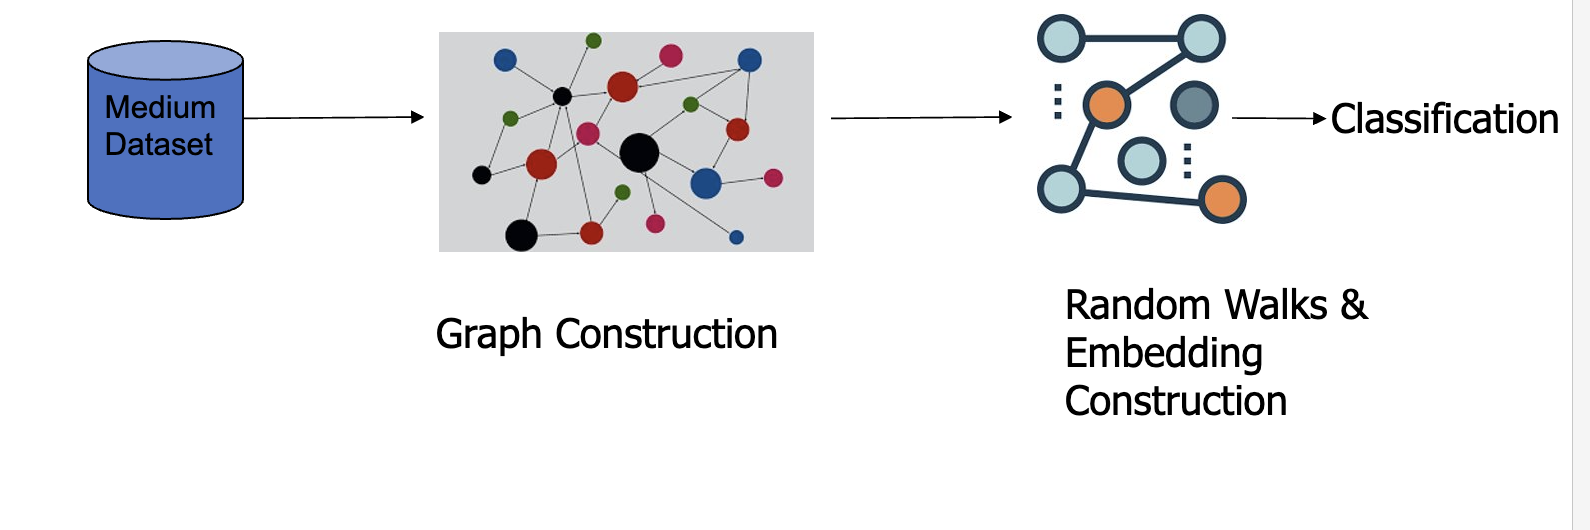

### Form graph

Our goal is to contruct a graph from  given data by connecting nodes that atleast share one common subscription list. The networkx part has already been written for you. 

Your task here is to write the module to construct the edges and find isolated nodes and also analyze the resulting graph by reporting number of edges, number of nodes, number of isolated nodes. 



In [20]:
from typing import List,Dict

def get_edges(data: pd.DataFrame, nodes) -> List:
    """ Given the dataframe with articles and lists return the set of edges
        Args:
        data (pd.DataFrame): The medium dataset
        nodes: dict (nodeid: article title)
    Returns:
            edges (List[tuple]): List of edges"""
    edges = []    
    ## START
    lists_to_articles: dict[str, list[int]] = {}

    for index, row in data.iterrows():
        art_lists_str = row["list"]
        art_lists = art_lists_str.split("; ")
        
        for art_list in art_lists:
            if art_list not in lists_to_articles:
                lists_to_articles[art_list] = [index]
            else:
                lists_to_articles[art_list].append(index)
    
    for list in lists_to_articles:
        list: str
        list_articles: list[int] = lists_to_articles[list]
        for from_index in list_articles:
            for to_index in list_articles:
                if from_index == to_index:
                    continue
                if from_index not in nodes or to_index not in nodes:
                    continue
                edges.append((from_index, to_index))
    ##END
    return edges

In [70]:
def get_nodes(data: pd.DataFrame) -> Dict:
    """ Given the dataframe with articles and lists return the set of nodes
        Args:
        data (pd.DataFrame): The medium dataset
    Returns:
        nodes: dict (nodeid: article title)"""
    nodes = {}
    for index, row in data.iterrows():
        if index not in nodes:
            nodes[index] = row["title"]
    #print(f"Number of nodes: {len(nodes)}")
    return nodes

In [22]:
import networkx as nx
def form_graph(data: pd.DataFrame) -> nx.Graph:
    """Forms graph from medium article dataset.

    Args:
        data (pd.DataFrame): The medium dataset

    Returns:
        G (nx.Graph): The graph.

       """
    texts = [x[0]+" " + x[1] for x in zip(data.title,data.subtitle)]
    nodes = get_nodes(data)
    edges = get_edges(data, nodes)
    graph = nx.Graph()
    graph.add_nodes_from(list(nodes.keys()))
    graph.add_edges_from(edges)
    return graph


In [71]:
graph = form_graph(final_data)

In [72]:
edges = get_edges(final_data, get_nodes(final_data))
print(len(edges))

4514380


### Node2Vec

Here the task is to perform random walks on the graph formed in the previous step and compute embeddings for the nodes using the random walk results.

You can use gensim to compute embeddings, however for random walks you are expected to implement without relying on networkx. Your weblab assignment would aid you in the same. For gensim you are expected to use Word2Vec. However you  can explore on best ways to configure the hyperparams for your word2vec instance for better donwstream classification task.

### Forming the adjacency matrix
For the assignment part of forming the adjacency matrix, see "Form graph" section. At the end of the assignment, we realized we could have used the adjacency matrix for calculating isolated nodes (summing an axis). We did it a different way though.  

However, we can obtain the adjacency matrix from our method like so:

In [25]:
nx.adjacency_matrix(graph)

<27718x27718 sparse array of type '<class 'numpy.intc'>'
	with 4028324 stored elements in Compressed Sparse Row format>

In [26]:
# Find isolated nodes with no neighbors before random walks
### START
def calculate_isolated(graph: nx.Graph) -> list[int]:
    isolated: list[int] = []
    for node in graph.nodes:
        neighbours = graph.adj[node]
        if len(neighbours) == 0:
            isolated.append(node)
    return isolated


final_data_isolated: list[int] = calculate_isolated(graph)
print(f"Number of isolated nodes: {len(final_data_isolated)}")
### END

Number of isolated nodes: 347


In [27]:
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int, isolated: List) -> np.ndarray:
    """Perform random walks on the graph.

    Args:
        G (nx.Graph): The graph.
        num_walks (int): The number of random walks for each node.
        walk_length (int): The number of nodes in a random walk.
        isolated (List[int]): list of isolated nodeids

    Returns:
        np.ndarray: The random walks, shape (n_nodes * num_walks, walk_length)
    """
    result = []
    ### START
    # Iterate over all the nodes in the graph
    for start_node_id in graph.nodes:
        # Type hinting
        start_node_id: int

        # If this node is an isolated node, we don't do random walks
        if start_node_id in isolated:
            continue
        
        # Do a number of walks per node equal to num_walks
        for walk_id in range(num_walks):
            walk = []
            # Append the starting node to our walk, and set it as the current node
            walk.append(start_node_id)
            current_node: int = start_node_id
            
            # Do a number of steps equal to walk_length - 1, because we already have the start node in our walk
            for step in range(walk_length - 1):
                # Get the neighbours of the current node
                neighbours = graph.adj[current_node]
                
                # Pick one at random to walk to next
                next = np.random.choice(neighbours)
                
                # Append it to our walk, and set it as the new current node
                walk.append(next)
                current_node = next
            
            # Append the walk to our results
            result.append(walk)
    ## END
    return np.asarray(result)

In [28]:
walks = random_walks(graph, 8, 15, final_data_isolated)

In [29]:
from gensim.models import Word2Vec
def fit_node2vec(walks: np.ndarray, vector_size: int, window: int, epochs: int) -> Word2Vec:
    """Train a Node2Vec model on random walks. Uses the GenSim Word2Vec implementation.

    Args:
        walks (np.ndarray): The random walks.
        vector_size (int): Node representation size.
        window (int): Window width.
        epochs (int): Number of epochs.

    Returns:
        Word2Vec: The trained model.
    """
    ### START
    num_rows = walks.shape[0]
    num_cols = walks.shape[1]

    sentences = []
    for i in range(num_rows):
        row = walks[i,:]
        sentence = []
        for j in range(len(row)):
            sentence.append(str(row[j]))
        sentences.append(sentence)

    # print(len(sentences))
    # print(*sentences[0:9], sep="\n")
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, epochs=epochs)
    return model
    ### END

In [30]:
model = fit_node2vec(walks, 128, 5, 10)

In [31]:
# embeddings = {doc: model.dv[doc] for doc in model.dv.index_to_key}


In [32]:
def get_nodeids(data: pd.DataFrame):
    """Get nodeids from graph

    Args:
        data (pd.DataFrame): medium articles dataset

    Returns:
        nodes (dict): nodeids with mapped article titles
    """
    nodes = {}
    for index, row in data.iterrows():
        if row["index"] not in nodes:
            nodes[row["index"]] = row["title"]
    return nodes

In [33]:
"""Get train and test nodes from the graph
    """
train_nodes = get_nodeids(train)
test_nodes = get_nodeids(test)
train_nodes = list(train_nodes.keys())
test_nodes = list(test_nodes.keys())

print(train_nodes)

[3279, 26139, 9946, 2353, 8266, 26638, 903, 2162, 13638, 22432, 17021, 1102, 409, 5819, 22453, 11245, 21848, 11850, 18169, 26070, 19347, 21870, 8796, 3482, 5740, 24718, 15580, 25347, 2527, 424, 15373, 14210, 3141, 20120, 10492, 23579, 18708, 27355, 25159, 25939, 27627, 22567, 20479, 13942, 22046, 2993, 2689, 21608, 7817, 11494, 298, 17215, 27098, 18760, 16260, 27211, 25437, 24037, 33, 20782, 3573, 23481, 23609, 5546, 646, 6576, 17733, 14177, 3020, 24981, 3314, 9285, 9612, 10717, 1392, 5935, 9654, 3705, 16133, 10907, 17706, 23345, 83, 24000, 1767, 21053, 21599, 26268, 12513, 2256, 7891, 20223, 10984, 15519, 16784, 16952, 25542, 19799, 16649, 15242, 26358, 18734, 14932, 11439, 26922, 27456, 13238, 6453, 1950, 669, 18448, 8518, 24683, 21314, 9467, 21213, 23293, 22315, 15451, 3687, 25137, 1943, 16276, 18295, 9840, 3347, 2562, 5678, 25671, 3755, 22463, 18071, 12768, 4026, 22612, 26988, 22839, 4770, 10397, 4385, 22478, 14733, 3408, 11090, 23176, 19085, 24179, 1455, 513, 14476, 2411, 7354, 27

In [34]:
len(test_nodes)

3950

In [35]:
"""Get node2vec embeddings (nodeid to embeddings mapping)
    """
embeddings = {word: model.wv[word] for word in model.wv.index_to_key}


In [36]:
print(embeddings["15737"])

[-0.5693165   1.0241857  -0.6873011   1.2351019   1.8664361   0.09253208
 -0.74117273  0.74565554  0.5397835   1.070875   -1.2504992   2.290567
  1.1467154  -1.3555353  -1.434531    0.7882001  -2.0050204  -0.6960708
  0.40751705  0.6243419   0.4040931  -0.07458618 -1.3413862   1.3023119
 -1.2310855   0.6005057  -0.19543654  3.3900492   0.08560547  1.8659767
  0.05913976  0.6249057  -0.84070736 -1.7090082   0.9508665   0.98584616
 -0.4964382   0.07614134 -1.0057644   1.0086595   0.22206184 -0.6497775
 -1.3912642   0.82912767  0.8988528   1.4866211   1.0733658   0.06801172
  0.56594133 -1.3533323  -0.68167233  0.34291503 -0.4683499  -1.4883697
  1.0399859  -0.53922254  1.7484443  -1.3687071   1.0018636   0.6227574
 -0.22087191  0.14952308  0.61975014 -3.0162094   0.6527562   0.9067836
  1.0412788   0.37782314  0.12353787 -1.9653287   0.6360015   0.8221883
 -0.7724274  -1.1341494  -0.89376736 -0.09211484  1.0357338  -0.9913406
 -1.977322    0.20438583 -1.4037452  -0.21937387 -0.47558525 -

### Word2vec + Node2vec

In [37]:
"""Compute train and test embeddings.
Concatenate the word2vec embeddings of article titles
with the node2vec embeddings using dictionary from previous step.
Dimension 1 of your embeddings should be 256.
Consider isolated nodes and handle them when computing embeddings"""
### START
# 1. Make the graph for train and test data
# 2. Calculate isolated nodes for train and test
# 3. Calculate random walks for train and test with their specific sets of isolated nodes
# 4. Fit node2vec model to random walks for train and test
# 5. Transform word vectors from node2vec to numpy arrays for train and test (num_nodes, vec_length = 128)
# 6. For each row, look up word2vec vector of title+subtitle for this node and append to row, making the new shape (num_nodes, vec_length = 256)
# Done?


# "Consider isolated": random walks already ignore isolated nodes, so they should be gone already.
# When looking up nodes from node2vec, we should have all non-isolated, so when looking up word2vec,
# we only look up non-isolated, even though word2vec still does have the isolated nodes.
### END

'Compute train and test embeddings.\nConcatenate the word2vec embeddings of article titles\nwith the node2vec embeddings using dictionary from previous step.\nDimension 1 of your embeddings should be 256.\nConsider isolated nodes and handle them when computing embeddings'

In [38]:
embeddings_n2v_with_train_w2v = {}

for key in embeddings:
    n2v = embeddings[key]

    train_to_final_idxs = train["index"]
    train_index = train_to_final_idxs[train_to_final_idxs == int(key)]
    if len(train_index) > 0:
        train_index = train_index.index[0]
    else: train_index = None

    # print(train_index)
    w2v = X_word2vec[train_index] if train_index is not None else np.zeros((128))

    n2v_with_w2v = np.concatenate((n2v, w2v))
    embeddings_n2v_with_train_w2v[key] = n2v_with_w2v

embeddings_n2v_with_test_w2v = {}

for key in embeddings:
    n2v = embeddings[key]

    test_to_final_idxs = test["index"]
    test_index = test_to_final_idxs[test_to_final_idxs == int(key)]
    if len(test_index) > 0:
        test_index = test_index.index[0]
    else: test_index = None

    # print(test_index)
    w2v = X_word2vec_test[test_index] if test_index is not None else np.zeros((128))

    n2v_with_w2v = np.concatenate((n2v, w2v))
    embeddings_n2v_with_test_w2v[key] = n2v_with_w2v

In [39]:
# TODO Assigning these is the assignment
X_train_n2v_w2v = np.array([embeddings_n2v_with_train_w2v[str(x)] if x not in final_data_isolated else np.zeros((256)) for idx, x in enumerate(train_nodes)], dtype=np.float32)
X_test_n2v_w2v = np.array([embeddings_n2v_with_test_w2v[str(x)] if x not in final_data_isolated else np.zeros((256)) for idx, x in enumerate(test_nodes)], dtype=np.float32)

In [40]:
X_train_n2v_w2v.shape,X_test_n2v_w2v.shape

((22382, 256), (3950, 256))

In [41]:
X_train_n2v_w2v.shape

(22382, 256)

In [42]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC,SVC

svc = SVC()
svc.fit(X_train_n2v_w2v,Y)

SVC()

In [43]:
Y.shape

(22382,)

In [44]:
X_train_n2v_w2v.shape

(22382, 256)

In [45]:
predictions = svc.predict(X_test_n2v_w2v)

In [46]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [47]:
from sklearn import metrics
print(metrics.f1_score(Y_test, predictions,average="macro"))


0.7348262196426605


In [48]:
print(metrics.classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1899
           1       0.86      0.79      0.82      2022
           2       0.86      0.41      0.56        29

    accuracy                           0.82      3950
   macro avg       0.83      0.69      0.73      3950
weighted avg       0.82      0.82      0.82      3950



### Only node2vec features

In [49]:
X_train_n2v = np.array([embeddings[str(x)] if x not in final_data_isolated else np.zeros((128)) for idx, x in enumerate(train_nodes)  ], dtype=np.float32)
X_test_n2v = np.array([embeddings[str(x)] if x not in final_data_isolated else np.zeros((128)) for idx, x in enumerate(test_nodes)  ], dtype=np.float32)

In [50]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC,SVC

svc = SVC()
svc.fit(X_train_n2v,Y)

SVC()

In [51]:
predictions = svc.predict(X_test_n2v)

In [52]:
from sklearn import metrics
print(metrics.f1_score(Y_test, predictions,average="macro"))


0.7145890200852941


In [53]:
print(metrics.classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1899
           1       0.84      0.73      0.78      2022
           2       0.86      0.41      0.56        29

    accuracy                           0.79      3950
   macro avg       0.82      0.67      0.71      3950
weighted avg       0.80      0.79      0.79      3950



 Compare performance of word2vec only, node2vec embeddings only (above) and word2vec+node2vec settings.
  Report your intuition below in text as to why one works better than other and to what extent network structure helps compare to only using word2vec embeddings of titles and subtitles (first result).

 You can also plot the the plot of embeddings to gain more intuition

## Analysis

The number of nodes, edges, and isolated nodes were calculated in the above code; but here they are again for convenience:

In [77]:
nodes = get_nodes(final_data)
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(get_edges(final_data, nodes))}")
print(f"Number of isolated nodes: {len(calculate_isolated(graph))}")

Number of nodes: 27718
Number of edges: 4514380
Number of isolated nodes: 347


This means that the average node has around 326 edges, and only a bit over 1% of nodes are isolated.

For the predictions on the Node2Vec features with Word2Vec features added we got a score of `0.73517`  
For the predictions on only the Node2Vec features we got a score of `0.71664`

It makes sense that with the Word2Vec features added, the score is slightly better, since articles of the same subject matter are bound to belong to the same topic tag. Articles dealing with similar subject matters will likely share some vocabulary in their titles and subtitles. Therefore, including these features in the predictive model is expected to give a higher accuracy, which we observe.

Below are tSNE manifolds of the two different embeddings. You can clearly see some clustering for similar articles

[[-47.57111   -57.522156 ]
 [ 23.344576   20.049791 ]
 [ 10.266617   -4.0944366]
 ...
 [-15.689067   -3.0192943]
 [-29.522762  -38.83085  ]
 [-25.070442  -61.85653  ]]


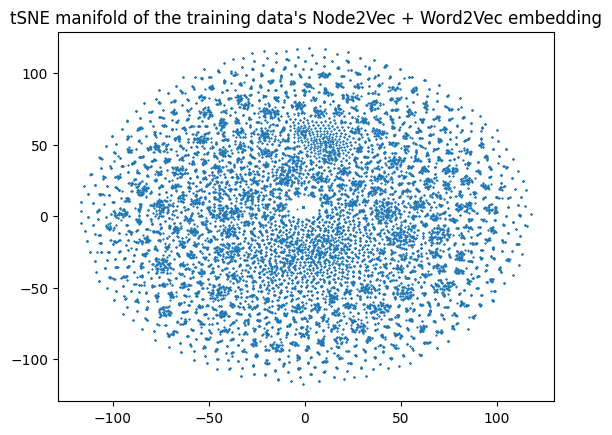

In [54]:
from sklearn.manifold import TSNE

# TODO Try this with PCA first
# TODO Try this after removing isolated
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train_n2v_w2v)
X_embedded.shape

plt.scatter(X_embedded[:,0], X_embedded[:,1], marker=".",lw=0,s=8)
print(X_embedded)
plt.title("tSNE manifold of the training data's Node2Vec + Word2Vec embedding")
plt.show()

[[-41.3563    -46.410206 ]
 [ 32.32754     1.1756463]
 [-13.061871   29.113167 ]
 ...
 [ 10.14489   -16.880085 ]
 [-51.7533     14.367682 ]
 [ 29.856714  -67.1614   ]]


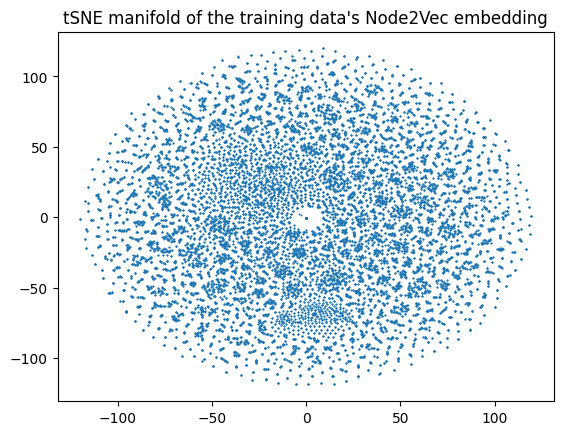

In [55]:
from sklearn.manifold import TSNE

# TODO Try this with PCA first
# TODO Try this after removing isolated
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train_n2v)
X_embedded.shape

plt.scatter(X_embedded[:,0], X_embedded[:,1], marker=".",lw=0,s=8)
print(X_embedded)
plt.title("tSNE manifold of the training data's Node2Vec embedding")
plt.show()

# Random bits of discarded code
Not necessarily applicable to the assignment, but preserved for posterity

You can collapse the "*Random bits of code*" header to hide all the below.

## The below code is not for grading

## Stop reading unless you're morbidly curious in discarded code

In [56]:
# # Make a graph for the train and test data
# train_graph = form_graph(train)
# test_graph = form_graph(test)

In [57]:
# # Calculating isolated nodes for train and test data
# train_isolated = calculate_isolated(train_graph)
# test_isolated = calculate_isolated(test_graph)

# print(len(final_data_isolated))
# print(len(train_isolated))
# print(len(test_isolated))

In [58]:
# # Simulate random walks for train and test data, taking into account their specific isolated nodes

# train_walks = random_walks(train_graph, 8, 15, train_isolated)
# test_walks = random_walks(test_graph, 8, 15, test_isolated)

In [59]:
# X_train_n2v_only = fit_node2vec(train_walks, 128, 5, 10)
# X_test_n2v_only = fit_node2vec(test_walks, 128, 5, 10)

In [60]:
# # Combining n2v with w2v for train data 
# X_train_keys = X_train_n2v_only.wv.index_to_key
# X_train_n2v_with_w2v = np.zeros((len(train), 256))
# print(X_train_n2v_only.wv[0])

# # X_word2vec is indexed on train data
# # X_train_keys is indexed on train data
# X_train_keys = [int(element) for element in X_train_keys]
# X_train_keys.sort()

# i = 0
# for train_index in X_train_keys:
#     train_index_str = str(train_index)
#     n2v_wv = X_train_n2v_only.wv[train_index_str]
#     # Word2vec is indexed on final data? Try other index
#     w2v_wv = X_word2vec[train_index]
#     n2v_with_w2v = np.concatenate((n2v_wv, w2v_wv))
#     X_train_n2v_with_w2v[i,:] = n2v_with_w2v
#     i += 1

# # Combining n2v with w2v for test data
# X_test_keys = X_test_n2v_only.wv.index_to_key
# X_test_n2v_with_w2v = np.zeros((len(test), 256))

# # X_word2vec is indexed on train data
# # X_test_keys is indexed on train data
# X_test_keys = [int(element) for element in X_test_keys]
# X_test_keys.sort()

# i = 0
# for test_index in X_test_keys:
#     test_index_str = str(test_index)
#     n2v_wv = X_test_n2v_only.wv[test_index_str]
#     w2v_wv = X_word2vec_test[test_index]
#     n2v_with_w2v = np.concatenate((n2v_wv, w2v_wv))
#     X_test_n2v_with_w2v[i,:] = n2v_with_w2v
#     i += 1

# print(X_train_keys)
# print(X_test_keys)